""" -----Phase 1 Project File -----
filestarted on 6 May 2023

 FIVE DATASETS: 
1. SQL - MOVIE DATA, im.db
2. CSV - MOVIE BUDGETS, movie_budgets.csv
3. CSV - movie grosses, bom.movie_gross.csv
4. TSV - movie info, rt.movie_info.tsv 
5. TSV - reviews, rt.reviews.tsv
6. CSV - movies, tmdb_movies.csv"""

In [60]:
# Import necessary packages

import pandas as pd
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
import os
import zlib
import zipfile
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path  
import glob
from matplotlib import font_manager
import seaborn as sns


In [61]:
#Print pandas version
print(pd.__version__)

2.0.1


In [62]:
#This is a function to find the number of missing values per column in a dataframe
def missing_values(df_name):
    """This function iterates to find the number of missing values per column"""
    print ("Missing values by Column")
    for col in df_name.columns:
        missing = df_name[col].isna().sum()
        print (str(col) + ": " + str(missing) + " missing values")
    return

In [63]:
# This is a function to create a table of Value Counts for a particular column
def column_value_counts(df_name, col_name):
    list1 = []
    list_dict = {}
    for index, row in df_name.iterrows():
        value = row[col_name]
        if value in list1:
            list_dict[col_name] +=1
            continue
        else:
            list1.append(value)
            list_dict[col_name] = 1

    print("There are " + str(len(list1)) + " unique.")
    return

#1 SQL - Movie Data

In [64]:
# 1) SQL - MOVIE DATA  

# Extract SQL db from zip
# ZipFile.extractall(file_path , members=None, pwd=None)Home\MovieData\


#textFile = zipfile.ZipFile("/home/hatenotwelcome/MovieData/im.db.zip", "r")
#textFile.close()

#SQL DB includes 8 tables: principals, known-for, directors, writers, persons, movie_basics, movie_ratings, movie_akas
# principals: *movie_id, 

conn = sqlite3.Connection("/home/bringingthesparkle/FlatIron/Movie_Data/im.db")

q = """
SELECT movie_id, primary_title, original_title as 'Original Title', start_year as 'Start Year', runtime_minutes as 'Runtime in Minutes', genres
FROM  movie_basics
;
"""

pd.read_sql(q, conn)

movie_basics_df = pd.read_sql(q, conn)
print(movie_basics_df.columns)

# Connection closed at bottome of file

Index(['movie_id', 'primary_title', 'Original Title', 'Start Year',
       'Runtime in Minutes', 'genres'],
      dtype='object')


In [65]:
missing_values(movie_basics_df)

Missing values by Column
movie_id: 0 missing values
primary_title: 0 missing values
Original Title: 21 missing values
Start Year: 0 missing values
Runtime in Minutes: 31739 missing values
genres: 5408 missing values


In [66]:
movie_basics_df['genres'].replace(np.nan, 'Unknown', inplace=True)
movie_basics_df.head(2)

,movie_id,primary_title,Original Title,Start Year,Runtime in Minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


In [67]:
movie_basics_df.dtypes

movie_id               object
primary_title          object
Original Title         object
Start Year              int64
Runtime in Minutes    float64
genres                 object
dtype: object

In [68]:
#Checking to see if movie_id is a unique identifier
mb_df_list = movie_basics_df['movie_id']

print(len(movie_basics_df['movie_id']))
print(len(set(mb_df_list)))

print(movie_basics_df.head(2))

146144
146144
    movie_id                    primary_title   Original Title  Start Year   
0  tt0063540                        Sunghursh        Sunghursh        2013  \
1  tt0066787  One Day Before the Rainy Season  Ashad Ka Ek Din        2019   

   Runtime in Minutes              genres  
0               175.0  Action,Crime,Drama  
1               114.0     Biography,Drama  


In [69]:
#String split, splits list like entries into actual lists
movie_basics_df['genres'] = movie_basics_df['genres'].str.split(',')
movie_basics_df.head()

,movie_id,primary_title,Original Title,Start Year,Runtime in Minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"[Action, Crime, Drama]"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"[Biography, Drama]"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,[Drama]
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"[Comedy, Drama]"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"[Comedy, Drama, Fantasy]"


In [70]:
#Using explode() to get the long form
dfnew = movie_basics_df.explode('genres')
dfnew.head()

,movie_id,primary_title,Original Title,Start Year,Runtime in Minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Action
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Crime
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Drama
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Biography
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Drama


In [71]:
# Now this data is ready to be merged with the financial data.  This data is contained within the moviebudgets csv.  Will continue with other SQL queries here
# since the file is open.

In [72]:
q = """
SELECT *
FROM  directors
;
"""

directors_df = pd.read_sql(q, conn)
print(directors_df.head(5))

print(len(directors_df))

# for some reason in this table, movie_ID is not unique and many are true duplicates, in that they are not representing more than one director (the person_id is the same).
# I will dedupe here before merging the pandas dfs.
# The query was written in SQL but I would rather de-dupe before merging for clarity.  Will use SQL DISTINCT for this.

    movie_id  person_id
0  tt0285252  nm0899854
1  tt0462036  nm1940585
2  tt0835418  nm0151540
3  tt0835418  nm0151540
4  tt0878654  nm0089502
291174


In [73]:
# Inner joining directors on persons because I want all directors but not all persons, and I really only care about directors who have information in the table

q = """
SELECT DISTINCT movie_id, person_id, primary_name as 'Director Name', birth_year as 'Birth Year', death_year as 'Death Year', primary_profession as Professions
FROM  directors
INNER JOIN persons
USING (person_id)
;
"""

directors_df2 = pd.read_sql(q, conn)
print(directors_df2.head(5))

print(len(directors_df2)) 
# This bring the total count down to 163,535 values

    movie_id  person_id      Director Name  Birth Year  Death Year   
0  tt0285252  nm0899854        Tony Vitale      1964.0         NaN  \
1  tt0462036  nm1940585         Bill Haley         NaN         NaN   
2  tt0835418  nm0151540  Jay Chandrasekhar      1968.0         NaN   
3  tt0878654  nm0089502        Albert Pyun      1954.0         NaN   
4  tt0878654  nm2291498          Joe Baile         NaN         NaN   

                           Professions  
0             producer,director,writer  
1             director,writer,producer  
2                director,actor,writer  
3             director,writer,producer  
4  producer,director,camera_department  
163533


In [74]:
# Doing the same with writers. Again I need all writers not all persons, but I only care about the writers with data so an inner join
q = """
SELECT DISTINCT movie_id, person_id, primary_name as 'Writer Name', birth_year as 'Birth Year', death_year as 'Death Year', primary_profession as Professions
FROM  writers
INNER JOIN persons
USING (person_id)
;
"""

writers_df = pd.read_sql(q, conn)
print(writers_df.head(15))

print(len(writers_df)) 

      movie_id   person_id          Writer Name  Birth Year  Death Year   
0    tt0285252   nm0899854          Tony Vitale      1964.0         NaN  \
1    tt0438973   nm0175726         Steve Conrad      1968.0         NaN   
2    tt0438973   nm1802864        Sean Sorensen         NaN         NaN   
3    tt0462036   nm1940585           Bill Haley         NaN         NaN   
4    tt0835418   nm0310087         Peter Gaulke         NaN         NaN   
5    tt0835418   nm0841532        Gerry Swallow         NaN         NaN   
6    tt0878654   nm0284943      Randall Fontana         NaN         NaN   
7    tt0996958   nm2286991        Tara Cardinal      1978.0         NaN   
8    tt0996958   nm2651190         Kim Pritekel      1976.0         NaN   
9    tt0999913   nm0527109            Rod Lurie      1962.0         NaN   
10   tt0999913   nm0329051  David Zelag Goodman      1930.0      2011.0   
11   tt0999913   nm0001603        Sam Peckinpah      1925.0      1984.0   
12   tt0999913   nm093068

In [75]:
# Creating new merged dataframes.  One with directors and budget information, and one with writers and budget information.
sql_merge_df1 = pd.merge(movie_basics_df, directors_df2, left_on='movie_id', right_on='movie_id', how='left')
sql_merge_df2 = pd.merge(sql_merge_df1, writers_df, left_on='movie_id', right_on='movie_id', how='left')
print((sql_merge_df1.shape)) # This yields a shape of 169262x11 which means there ARE records in the movie_basics that do not have entries in the directors table.
print((sql_merge_df2.shape))
print(sql_merge_df2.head(10))

#This has multiple records with the same title, but they have different writer IDs, or other fields, not duplicates

(169261, 11)
(297361, 16)
    movie_id                    primary_title              Original Title   
0  tt0063540                        Sunghursh                   Sunghursh  \
1  tt0063540                        Sunghursh                   Sunghursh   
2  tt0063540                        Sunghursh                   Sunghursh   
3  tt0063540                        Sunghursh                   Sunghursh   
4  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
5  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
6  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
7  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
8  tt0100275         The Wandering Soap Opera       La Telenovela Errante   
9  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   Start Year  Runtime in Minutes                    genres person_id_x   
0        2013               175.0    [Action, Crime

In [76]:
#Using explode() to get the long form
sql_merge_xplod1 = sql_merge_df1.explode('genres')
sql_merge_xplod1.tail(5)

,movie_id,primary_title,Original Title,Start Year,Runtime in Minutes,genres,person_id,Director Name,Birth Year,Death Year,Professions
169256,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary,nm9272491,Ana Célia de Oliveira,NaN,NaN,"producer,director,writer"
169257,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy,nm7764440,Kanchan Nayak,NaN,NaN,director
169258,tt9916730,6 Gunn,6 Gunn,2017,116.0,Unknown,nm10538612,Kiran Gawade,NaN,NaN,None
169259,tt9916754,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,2013,NaN,Documentary,nm9272490,Angela Gurgel,NaN,NaN,"director,writer"
169260,tt9916754,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,2013,NaN,Documentary,nm8349149,Vinicius Augusto Bozzo,1985.0,NaN,"writer,editor,director"


In [77]:
#Using explode() to get the long form
sql_merge_xplod2 = sql_merge_df2.explode('genres')
sql_merge_xplod2.head()

,movie_id,primary_title,Original Title,Start Year,Runtime in Minutes,genres,person_id_x,Director Name,Birth Year_x,Death Year_x,Professions_x,person_id_y,Writer Name,Birth Year_y,Death Year_y,Professions_y
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Action,nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer",nm0023551,Abrar Alvi,1927.0,2009.0,"writer,actor,director"
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Crime,nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer",nm0023551,Abrar Alvi,1927.0,2009.0,"writer,actor,director"
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Drama,nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer",nm0023551,Abrar Alvi,1927.0,2009.0,"writer,actor,director"
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,Action,nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer",nm1194313,Mahasweta Devi,1926.0,2016.0,writer
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,Crime,nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer",nm1194313,Mahasweta Devi,1926.0,2016.0,writer


In [78]:
# When I tried to merge this info on title, I got almost no results and I needed to check the titles.  The primary title appears to be in English and the Original Title 
# appears to be in the original language which may have been part of the problem.
weird_titles = sql_merge_df2['primary_title']
list = weird_titles.tolist()
print(set(list[0:500]))

{'The Tree of Life', '7 Days', 'Alita: Battle Angel', 'Alan Partridge', 'Stolen Memories', 'Bandage', 'Disconnect', 'Lives No Longer Ours', 'Federal', 'Party Crashers', '42', 'Generation P', 'Cloud Cuckoo Land', 'Scott Pilgrim vs. the World', 'The Wicker Tree', 'Captain America: The First Avenger', 'Seven Jews from My Class', 'Sushi in Suhl', 'The Equalizer', 'Stan', 'A Woman Is a Woman', 'The Evil Within', 'Bubbles', 'Pots and Pans', 'Bamboo Shark', 'The A-Team', 'The Crazies', 'Dinner for Schmucks', 'American Pastoral', 'Children of the Green Dragon', 'Spy', 'Vidas pequeñas', 'Dark Blood', 'The Rum Diary', 'The Connecticut Kid', 'Godfather', 'Piranha 3D', 'Red Tails', 'Cowboys & Aliens', 'The Ninth Cloud', 'Caleuche: El llamado del Mar', 'Life of Pi', 'The Other Side of the Wind', 'A Bird of the Air', 'A Long Way Down', 'Gangavataran', 'Snowblind', 'Ex Machina', 'El borde del tiempo', 'The Queen of Sheba Meets the Atom Man', 'One Day Before the Rainy Season', 'To Chase a Million', 'T

In [79]:
# Closing the SQL file connection
conn.close()

#2 Movie Budgets CSV

In [80]:
# This is the file tn.movie_budgets.csv.gz. This is the only file with the budgets and grosses from which you can obtain the ROI.  This file did not come with a readme.
# Domestic gross is assumed to be in the USA and worldwide gross is is assumed to be everywhere else, rather than domestic gross being a subset of worldwide gross.

movie_budgets = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/tn.movie_budgets.csv.gz', sep=',')
print(movie_budgets.shape)
print(movie_budgets.dtypes)
print(movie_budgets.tail(5))
print('\n')

missing_values(movie_budgets)

(5782, 6)
id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object
      id  release_date                          movie production_budget   
5777  78  Dec 31, 2018                         Red 11            $7,000  \
5778  79   Apr 2, 1999                      Following            $6,000   
5779  80  Jul 13, 2005  Return to the Land of Wonders            $5,000   
5780  81  Sep 29, 2015           A Plague So Pleasant            $1,400   
5781  82   Aug 5, 2005              My Date With Drew            $1,100   

     domestic_gross worldwide_gross  
5777             $0              $0  
5778        $48,482        $240,495  
5779         $1,338          $1,338  
5780             $0              $0  
5781       $181,041        $181,041  


Missing values by Column
id: 0 missing values
release_date: 0 missing values
movie: 0 missing values
production_budget: 0 missi

In [81]:
# String cleaning to turn budget and gross figures into numeric values, and compute the ROI.
movie_budgets["production_budget"] = movie_budgets["production_budget"].str.replace("$","").str.replace(",","")
movie_budgets["production_budget"] = pd.to_numeric(movie_budgets["production_budget"])
movie_budgets["domestic_gross"] = movie_budgets["domestic_gross"].str.replace("$","").str.replace(",","")
movie_budgets["domestic_gross"] = pd.to_numeric(movie_budgets["domestic_gross"])
movie_budgets["worldwide_gross"] = movie_budgets["worldwide_gross"].str.replace("$","").str.replace(",","")
movie_budgets["worldwide_gross"] = pd.to_numeric(movie_budgets["worldwide_gross"])
movie_budgets["ROI"] = ((movie_budgets["domestic_gross"] + movie_budgets["worldwide_gross"]) - movie_budgets["production_budget"])
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,876127750
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-157475300
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1531419831
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,1619903129


In [82]:
# Now that ROI has been calculated, can sort by ROI
movie_budgets.sort_values('ROI', ascending = False, inplace=True)
print(movie_budgets.head(2))

   id  release_date                                 movie  production_budget   
0   1  Dec 18, 2009                                Avatar          425000000  \
5   6  Dec 18, 2015  Star Wars Ep. VII: The Force Awakens          306000000   

   domestic_gross  worldwide_gross         ROI  
0       760507625       2776345279  3111852904  
5       936662225       2053311220  2683973445  


In [83]:
# Calculate percentiles
data = np.array(movie_budgets['ROI'])
print("The number of records is " + str(len(data)))
q75, q25 = np.percentile(data, [75 ,25])
iqr = q75 - q25
print ("75th percentile is at " + str(q75))
print("25th percentile is at " + str(q25))
top_25_pct = movie_budgets[movie_budgets['ROI']> q75]
print(type(top_25_pct))
bottom_25_pct = movie_budgets[movie_budgets['ROI']< q25 ]
#iqr_range = movie_budgets.loc[[movie_budgets['ROI']> q25] & [movie_budgets['ROI']<q75]]
print("The number of records in the bottom quartile is " + str(len(top_25_pct)))
print("The number of records in the bottom quartile is " + str(len(bottom_25_pct)))

The number of records is 5782
75th percentile is at 111164787.5
25th percentile is at -309822.25
<class 'pandas.core.frame.DataFrame'>
The number of records in the bottom quartile is 1446
The number of records in the bottom quartile is 1446


In [84]:
top_25_pct.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2683973445
42,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2426949682
33,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,2086125489


In [85]:
# In order to create some plots, I will need the year.  Will strip from the release_date and append new column.
movie_budgets['Year'] = movie_budgets['release_date'].str.strip().str[-4:]
movie_budgets.sort_values('Year', ascending = True, inplace=True)
print(movie_budgets.head(3))

      id  release_date                         movie  production_budget   
5677  78   Feb 8, 1915         The Birth of a Nation             110000  \
5523  24   Sep 5, 1916                   Intolerance             385907   
5614  15  Dec 24, 1916  20,000 Leagues Under the Sea             200000   

      domestic_gross  worldwide_gross       ROI  Year  
5677        10000000         11000000  20890000  1915  
5523               0                0   -385907  1916  
5614         8000000          8000000  15800000  1916  


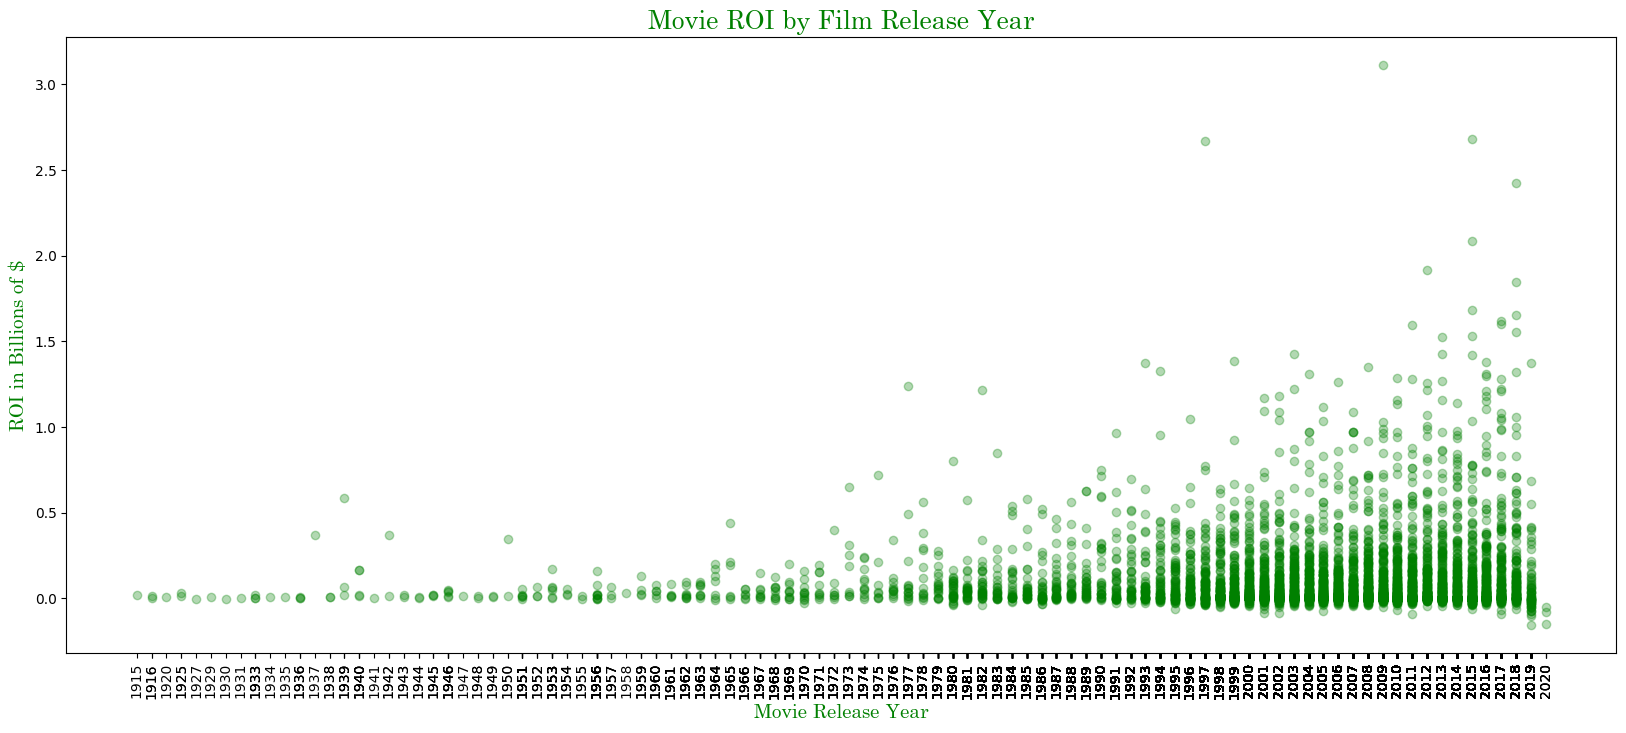

In [86]:
# Create a scatter-plot
fig, ax = plt.subplots(figsize=(20, 8))

font1 = {'family':'suranna','color':'green','size':20}
font2 = {'family':'suranna','color':'green','size':15}

ax.scatter(
    x=movie_budgets["Year"], y=((movie_budgets["ROI"])/1000000000), alpha=0.3, c='green'
)

ax.set_xticks((movie_budgets['Year']))
ax.set_xticklabels(movie_budgets['Year'], rotation = 90)
ax.set_xlabel("Movie Release Year", fontdict = font2)
ax.set_ylabel("ROI in Billions of $", fontdict = font2)
ax.set_title("Movie ROI by Film Release Year", fontdict=font1);

In [87]:
# New merge of SQL data on movie name 
print(type(top_25_pct))
print(len(top_25_pct))
print(top_25_pct.columns)
print(sql_merge_df2.columns)
print(type(sql_merge_df2))
print(len(sql_merge_df2))

# Changing 'movie' columns from object to string so that I can merge on them
top_25_pct['movie'] = top_25_pct['movie'].astype(str)
sql_merge_df2['primary_title'] = sql_merge_df2['primary_title'].astype(str)
#print(top_25_pct.dtypes)
#print(sql_merge_df2.dtypes)

roi_sql_merge_df2 = pd.merge(top_25_pct, sql_merge_df2, how='inner', left_on='movie', right_on='primary_title')
print(len(roi_sql_merge_df2))
print(top_25_pct['movie'].head())
print(sql_merge_df2['primary_title'].head())

#(297361, 16) there were 16 columns in the sql df and 7 in the $ df so columns are correct

<class 'pandas.core.frame.DataFrame'>
1446
Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'ROI'],
      dtype='object')
Index(['movie_id', 'primary_title', 'Original Title', 'Start Year',
       'Runtime in Minutes', 'genres', 'person_id_x', 'Director Name',
       'Birth Year_x', 'Death Year_x', 'Professions_x', 'person_id_y',
       'Writer Name', 'Birth Year_y', 'Death Year_y', 'Professions_y'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
297361
2681
0                                   Avatar
5     Star Wars Ep. VII: The Force Awakens
42                                 Titanic
6                   Avengers: Infinity War
33                          Jurassic World
Name: movie, dtype: object
0                          Sunghursh
1                          Sunghursh
2                          Sunghursh
3                          Sunghursh
4    One Day Before the Rainy Season
Name: primary_title, dtype: object


/tmp/ipykernel_7318/898515544.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_25_pct['movie'] = top_25_pct['movie'].astype(str)


In [88]:
roi_sql_merge_df2.head(5)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,movie_id,primary_title,Original Title,...,person_id_x,Director Name,Birth Year_x,Death Year_x,Professions_x,person_id_y,Writer Name,Birth Year_y,Death Year_y,Professions_y
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,tt1775309,Avatar,Abatâ,...,nm3786927,Atsushi Wada,NaN,NaN,director,nm2179863,Yûsuke Yamada,NaN,NaN,writer
1,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,tt1775309,Avatar,Abatâ,...,nm3786927,Atsushi Wada,NaN,NaN,director,nm4392664,Teruo Noguchi,NaN,NaN,"director,writer,editor"
2,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,tt2495766,Titanic,Titanic,...,nm4430776,Pete Meads,NaN,NaN,"actor,camera_department,miscellaneous",nm5410036,Kevin Lincoln,NaN,NaN,"director,actor,writer"
3,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,tt2495766,Titanic,Titanic,...,nm5410036,Kevin Lincoln,NaN,NaN,"director,actor,writer",nm5410036,Kevin Lincoln,NaN,NaN,"director,actor,writer"
4,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,tt8852130,Titanic,Titanic,...,nm10047650,Ravi Punj,NaN,NaN,"director,writer,producer",nm10047650,Ravi Punj,NaN,NaN,"director,writer,producer"


In [89]:
# This is the cleaning and selecting for a graph of ROI by top film director with the full movie budgets dataset. 
# Will use Group by and aggregate functions to get the top directors by their totals and averages and then select only their
# records from the full dataset to create boxplots.

#Changing 'movie' columns from object to string so you can merge on them
top_25_pct['movie'] = top_25_pct['movie'].astype(str)
movie_budgets['movie'] = movie_budgets['movie'].astype(str)
sql_merge_df2['primary_title'] = sql_merge_df2['primary_title'].astype(str)

full_roi_sql_merge = pd.merge(movie_budgets, sql_merge_df2, how='inner', left_on='movie', right_on='primary_title')
print(full_roi_sql_merge.shape)
print(movie_budgets['movie'].head())
print(full_roi_sql_merge['primary_title'].head())

(9076, 24)
5677             The Birth of a Nation
5523                       Intolerance
5614      20,000 Leagues Under the Sea
5683    Over the Hill to the Poorhouse
4569     Ben-Hur: A Tale of the Christ
Name: movie, dtype: object
0    The Birth of a Nation
1    The Birth of a Nation
2    The Birth of a Nation
3    The Birth of a Nation
4                    Wings
Name: primary_title, dtype: object


/tmp/ipykernel_7318/477112367.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_25_pct['movie'] = top_25_pct['movie'].astype(str)


In [90]:
print(full_roi_sql_merge.head())

   id  release_date                  movie  production_budget  domestic_gross   
0  78   Feb 8, 1915  The Birth of a Nation             110000        10000000  \
1  78   Feb 8, 1915  The Birth of a Nation             110000        10000000   
2  17   Oct 7, 2016  The Birth of a Nation           10000000        15861566   
3  17   Oct 7, 2016  The Birth of a Nation           10000000        15861566   
4  85  Aug 12, 1927                  Wings            2000000               0   

   worldwide_gross       ROI  Year   movie_id          primary_title  ...   
0         11000000  20890000  1915  tt4196450  The Birth of a Nation  ...  \
1         11000000  20890000  1915  tt4196450  The Birth of a Nation  ...   
2         16891011  22752577  2016  tt4196450  The Birth of a Nation  ...   
3         16891011  22752577  2016  tt4196450  The Birth of a Nation  ...   
4                0  -2000000  1927  tt2284790                  Wings  ...   

  person_id_x  Director Name  Birth Year_x Death Y

In [91]:
#Ensure the df is sorted by ROI
full_roi_sql_merge.sort_values('ROI', ascending = False, inplace=True)
#Limit to the first 5000 records (#? top directors)
print(len(set(full_roi_sql_merge['Director Name'])))  #There are 3,242 unique Director Names in the merged dataframe
roi_sql_merge_slice = full_roi_sql_merge[:500]

dftest = full_roi_sql_merge.groupby(by='Director Name')['ROI'].agg('sum').sort_values( ascending=False)
print(dftest)
#dftest shows the top total overall summed ROI by Director
dftestslice = dftest

3242
Director Name
Anthony Russo        42541360685
Joe Russo            42541360685
Zack Snyder          15809376381
Peter Jackson        14947191275
Gareth Edwards       13611242955
                        ...     
Lawrence Kasanoff     -224631470
Ash Brannon           -237878694
Simon Wells           -267172452
Edwine Dorival        -427345770
Simon Kinberg         -944851800
Name: ROI, Length: 3241, dtype: int64


In [92]:
#This is the top directors from the full movie_budgets dataset by their average movie ROI
dftest2 = full_roi_sql_merge.groupby(by='Director Name')[['ROI',"domestic_gross"]].mean().sort_values(by='ROI', ascending=False)
dftest2.reset_index
 #This returns a series
print(type(dftest2))
print(dftest2.columns)
directors = dftest2.index.tolist()

#This is how to get the group names, and index locations
groups = full_roi_sql_merge.groupby(by='Director Name').groups
print(groups)

print(len(dftest2))
dftest2.head()

#get a list of the top 20 
dftest2slice = dftest2[0:20]
print(dftest2slice)
top20dir = directors[0:20]
print(top20dir)

<class 'pandas.core.frame.DataFrame'>
Index(['ROI', 'domestic_gross'], dtype='object')
{'Aaron Agrasanchez': [8853], 'Aaron Alon': [1427], 'Aaron Hann': [2662, 2663], 'Aaron Schnobrich': [2247], 'Aaron Seltzer': [2739, 2738], 'Aaron T. Wells': [4223, 4222, 4221], 'Aash Aaron': [157], 'Aashiq Abu': [1036, 1037, 1035], 'Abby Kohn': [8737, 8736], 'Abdolreza Kahani': [1624, 1623], 'Abeer Zeibak Haddad': [1934], 'Abhijit Guha': [874, 879], 'Abraham Galindo': [6466], 'Adam Brooks': [842, 841, 840, 839, 838], 'Adam Busch': [2642, 2643], 'Adam Carolla': [6713, 6714], 'Adam Ciancio': [6690], 'Adam Ethan Crow': [168], 'Adam Florian': [245, 231], 'Adam Green': [4844], 'Adam Liddicoatt': [1290, 1287, 1286, 1285, 1289, 1288], 'Adam McKay': [5435, 5436, 3047, 3046, 6592, 6591, 6590, 8672], 'Adam Montierth': [6090, 6091, 6089, 6088, 6087, 6086, 6085, 6083, 6084], 'Adam Rifkin': [6865], 'Adam Robitel': [8895], 'Adam Shankman': [8978, 8979, 8980, 8977, 8976, 8975, 8974, 4560, 4561, 4559], 'Adam Shaw': 

In [93]:
#New DF with only the rows from original merge of those top 20 directors
#df.loc[df['points'].isin([7,9,12])]
top20dirs_df = full_roi_sql_merge.loc[full_roi_sql_merge['Director Name'].isin(top20dir)]
top20dirs_df.sort_values('ROI', ascending = False, inplace=True)
print(len(top20dirs_df))
top20dirs_df.head()

113


/tmp/ipykernel_7318/2820506772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top20dirs_df.sort_values('ROI', ascending = False, inplace=True)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,Year,movie_id,primary_title,...,person_id_x,Director Name,Birth Year_x,Death Year_x,Professions_x,person_id_y,Writer Name,Birth Year_y,Death Year_y,Professions_y
2422,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,2009,tt1775309,Avatar,...,nm3786927,Atsushi Wada,NaN,NaN,director,nm4392664,Teruo Noguchi,NaN,NaN,"director,writer,editor"
2421,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,2009,tt1775309,Avatar,...,nm3786927,Atsushi Wada,NaN,NaN,director,nm2179863,Yûsuke Yamada,NaN,NaN,writer
882,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,1997,tt8852130,Titanic,...,nm10047650,Ravi Punj,NaN,NaN,"director,writer,producer",nm10047650,Ravi Punj,NaN,NaN,"director,writer,producer"
880,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,1997,tt2495766,Titanic,...,nm4430776,Pete Meads,NaN,NaN,"actor,camera_department,miscellaneous",nm5410036,Kevin Lincoln,NaN,NaN,"director,actor,writer"
881,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,1997,tt2495766,Titanic,...,nm5410036,Kevin Lincoln,NaN,NaN,"director,actor,writer",nm5410036,Kevin Lincoln,NaN,NaN,"director,actor,writer"


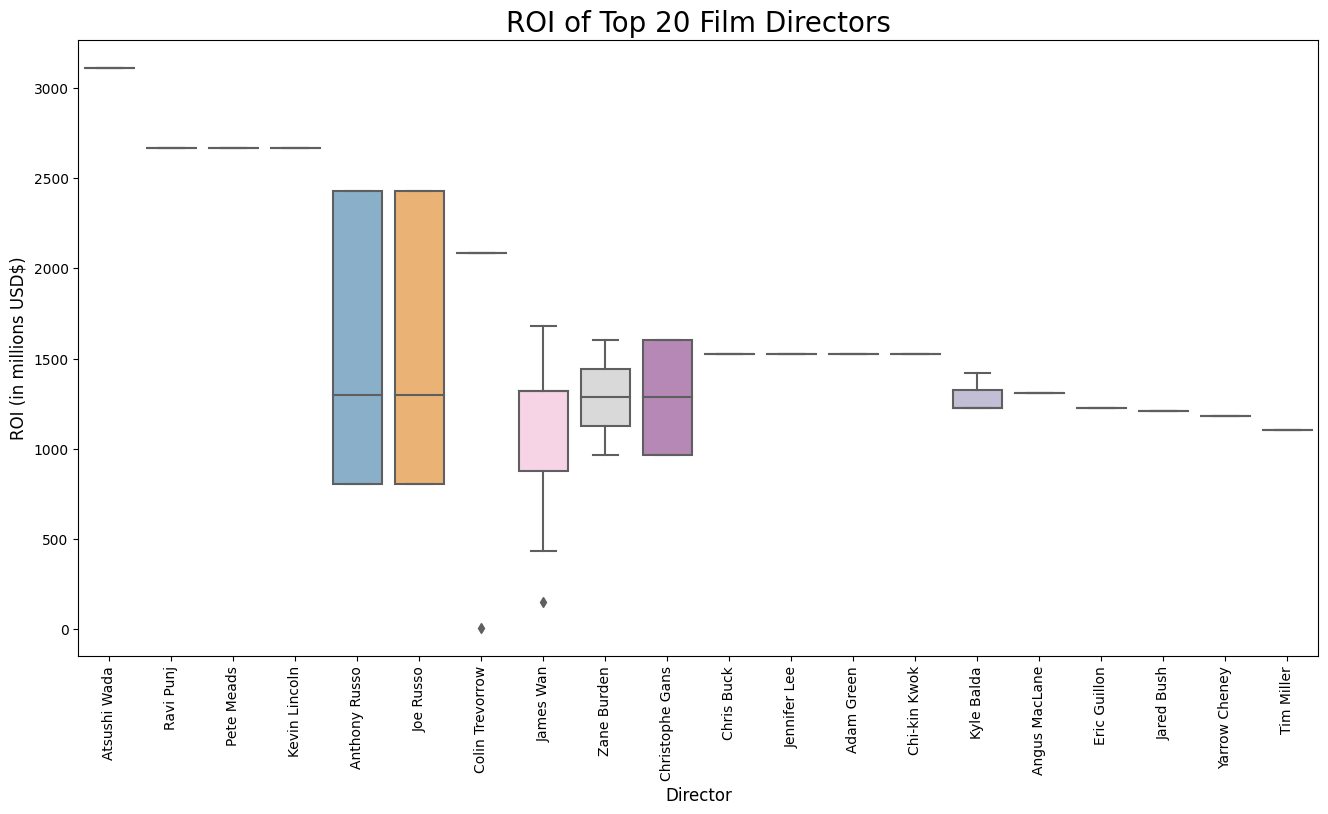

In [94]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.boxplot(x = 'Director Name', y='ROI', data = top20dirs_df, palette="Set3")
plt.title('ROI of Top 20 Film Directors', fontsize=20)
plt.xlabel('Director', fontsize=12)
plt.ylabel('ROI (in millions USD$)', fontsize=12)
ytick_values = [0, 0.5e9, 1e9, 1.5e9, 2e9, 2.5e9, 3e9]
ytick_labels = []
for value in ytick_values:
    label = (str(int(value/1000000)))
    ytick_labels.append(label)
plt.yticks(ticks=ytick_values, labels=ytick_labels)
plt.xticks(rotation=90);

In [95]:
#This is the top writers from the full movie_budgets dataset by their average movie ROI
dftest7 = full_roi_sql_merge.groupby(by='Writer Name')[['ROI',"domestic_gross"]].mean().sort_values(by='ROI', ascending=False)
dftest7.reset_index
 #This returns a series
print(type(dftest7))
print(dftest7.columns)
writers = dftest7.index.tolist()

#This is how to get the group names, and index locations
groups = full_roi_sql_merge.groupby(by='Writer Name').groups
print(groups)

print(len(dftest7))
dftest7.head()

#get a list of the top 20 
dftest7slice = dftest2[0:30]
print(dftest7slice)
top30wri = writers[0:30]
print(top30wri)

<class 'pandas.core.frame.DataFrame'>
Index(['ROI', 'domestic_gross'], dtype='object')
{'A. Jaye Williams': [1356], 'A. Scott Berg': [7809], 'A. Sreedhar': [948], 'A.A. Milne': [8810, 3472, 3482], 'A.C. Mughil': [416], 'Aaron Alon': [1427], 'Aaron Covington': [6449], 'Aaron Drane': [6708], 'Aaron Guzikowski': [4294, 5198], 'Aaron Hann': [2660, 2662], 'Aaron Kandell': [7473, 7481, 7497, 7489, 8854], 'Aaron McGruder': [4586], 'Aaron Seltzer': [2739, 2737], 'Aaron Sorkin': [3002, 3617, 7043], 'Aaron Stewart-Ahn': [8665], 'Aaron Stockard': [2814], 'Aaron Woolf': [7380, 7383], 'Aash Aaron': [157], 'Abai': [631], 'Abby Kohn': [4078, 2941, 8736, 8734], 'Abdolreza Kahani': [1623], 'Abdul Williams': [2805], 'Abdullah Zahir Babu': [2172, 2156], 'Abhijat Joshi': [6585], 'Abhiruchi Chand': [1768], 'Abi Morgan': [4315, 7052, 3814], 'Abinash Bikram Shah': [4189], 'Abraham Galindo': [6466], 'Ace Atkins': [1764], 'Adam Aresty': [7019], 'Adam Bolt': [2988], 'Adam Brooks': [838, 853, 858, 843, 848], 'Ad

In [96]:
top30wri_df = full_roi_sql_merge.loc[full_roi_sql_merge['Writer Name'].isin(top30wri)]
top30wri_df.sort_values('ROI', ascending = False, inplace=True)
print(len(top30wri_df))
top30wri_df.head()

65


/tmp/ipykernel_7318/3227083936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top30wri_df.sort_values('ROI', ascending = False, inplace=True)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,Year,movie_id,primary_title,...,person_id_x,Director Name,Birth Year_x,Death Year_x,Professions_x,person_id_y,Writer Name,Birth Year_y,Death Year_y,Professions_y
2422,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,2009,tt1775309,Avatar,...,nm3786927,Atsushi Wada,NaN,NaN,director,nm4392664,Teruo Noguchi,NaN,NaN,"director,writer,editor"
2421,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,2009,tt1775309,Avatar,...,nm3786927,Atsushi Wada,NaN,NaN,director,nm2179863,Yûsuke Yamada,NaN,NaN,writer
882,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,1997,tt8852130,Titanic,...,nm10047650,Ravi Punj,NaN,NaN,"director,writer,producer",nm10047650,Ravi Punj,NaN,NaN,"director,writer,producer"
880,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,1997,tt2495766,Titanic,...,nm4430776,Pete Meads,NaN,NaN,"actor,camera_department,miscellaneous",nm5410036,Kevin Lincoln,NaN,NaN,"director,actor,writer"
881,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,1997,tt2495766,Titanic,...,nm5410036,Kevin Lincoln,NaN,NaN,"director,actor,writer",nm5410036,Kevin Lincoln,NaN,NaN,"director,actor,writer"


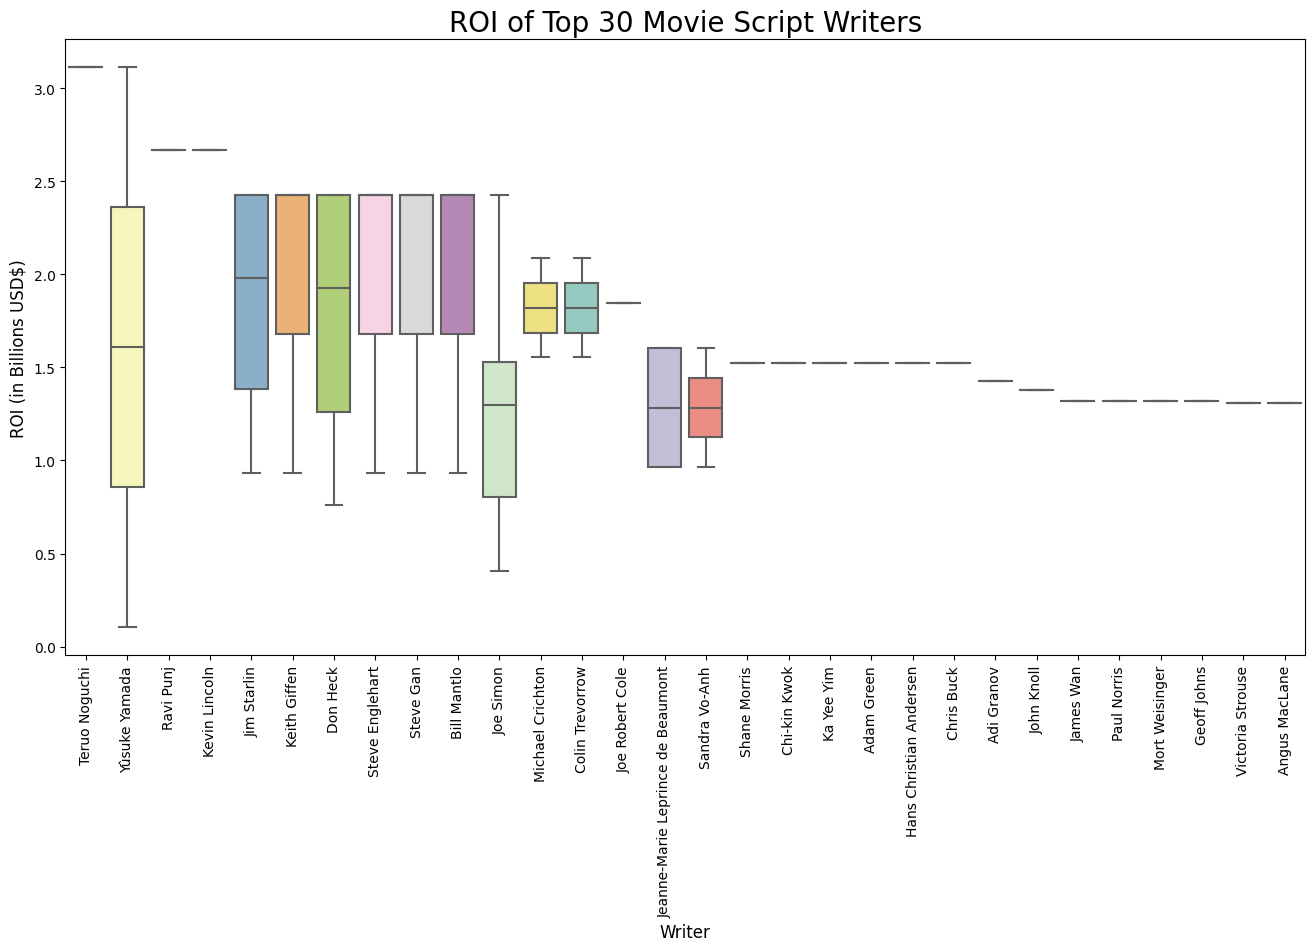

In [97]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.boxplot(x = 'Writer Name', y='ROI', data = top30wri_df, palette="Set3")
plt.title('ROI of Top 30 Movie Script Writers', fontsize=20)
plt.xlabel('Writer', fontsize=12)
plt.ylabel('ROI (in Billions USD$)', fontsize=12)
ytick_values = [0, 0.5e9, 1e9, 1.5e9, 2e9, 2.5e9, 3e9]
ytick_labels = []
for value in ytick_values:
    label = (str(float(value/1000000000)))
    ytick_labels.append(label)
plt.yticks(ticks=ytick_values, labels=ytick_labels)
plt.xticks(rotation=90);

In [98]:
explode_df = movie_basics_df.explode('genres')
explode_df.head()

,movie_id,primary_title,Original Title,Start Year,Runtime in Minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Action
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Crime
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Drama
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Biography
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Drama


In [99]:
explode_df.replace(np.nan, 'Unknown', inplace=True)
print(explode_df.head())

    movie_id                    primary_title   Original Title  Start Year   
0  tt0063540                        Sunghursh        Sunghursh        2013  \
0  tt0063540                        Sunghursh        Sunghursh        2013   
0  tt0063540                        Sunghursh        Sunghursh        2013   
1  tt0066787  One Day Before the Rainy Season  Ashad Ka Ek Din        2019   
1  tt0066787  One Day Before the Rainy Season  Ashad Ka Ek Din        2019   

  Runtime in Minutes     genres  
0              175.0     Action  
0              175.0      Crime  
0              175.0      Drama  
1              114.0  Biography  
1              114.0      Drama  


In [100]:
# Merge new exploded imdb data with top 25%  

top_25_pct['movie'] = top_25_pct['movie'].astype(str)
movie_budgets['movie'] = movie_budgets['movie'].astype(str)
sql_merge_xplod2['primary_title'] = sql_merge_xplod2['primary_title'].astype(str)
#print(top_25_pct.dtypes)
#print(sql_merge_df2.dtypes)

newdf = pd.merge(top_25_pct, explode_df , how='left', left_on='movie', right_on='primary_title')
newdf2 = pd.merge(movie_budgets, explode_df, how='left', left_on='movie', right_on='primary_title')

newdf2.sort_values('ROI', ascending = False, inplace=True)

/tmp/ipykernel_7318/3701265611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_25_pct['movie'] = top_25_pct['movie'].astype(str)


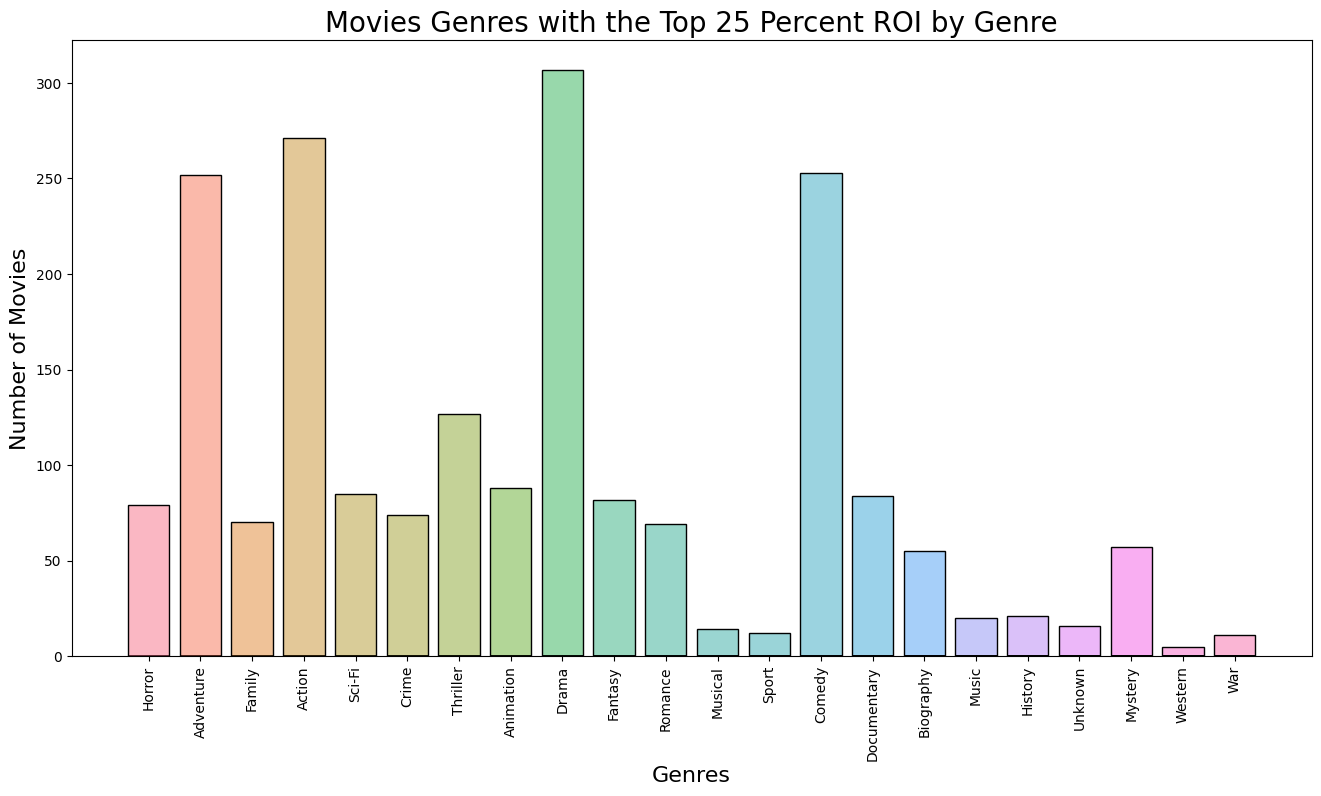

In [101]:
#Basic histogram of the frequency of movie genres in top 25%
plt.figure(figsize=(16,8))
sns.set_palette("husl")
sns.histplot(data=newdf, x="genres", hue="genres", shrink = 0.8, legend=False)
plt.title('Movies Genres with the Top 25 Percent ROI by Genre', fontsize=20)
plt.xlabel('Genres', fontsize=16)
plt.ylabel('Number of Movies', fontsize=16)
plt.xticks(rotation=90);

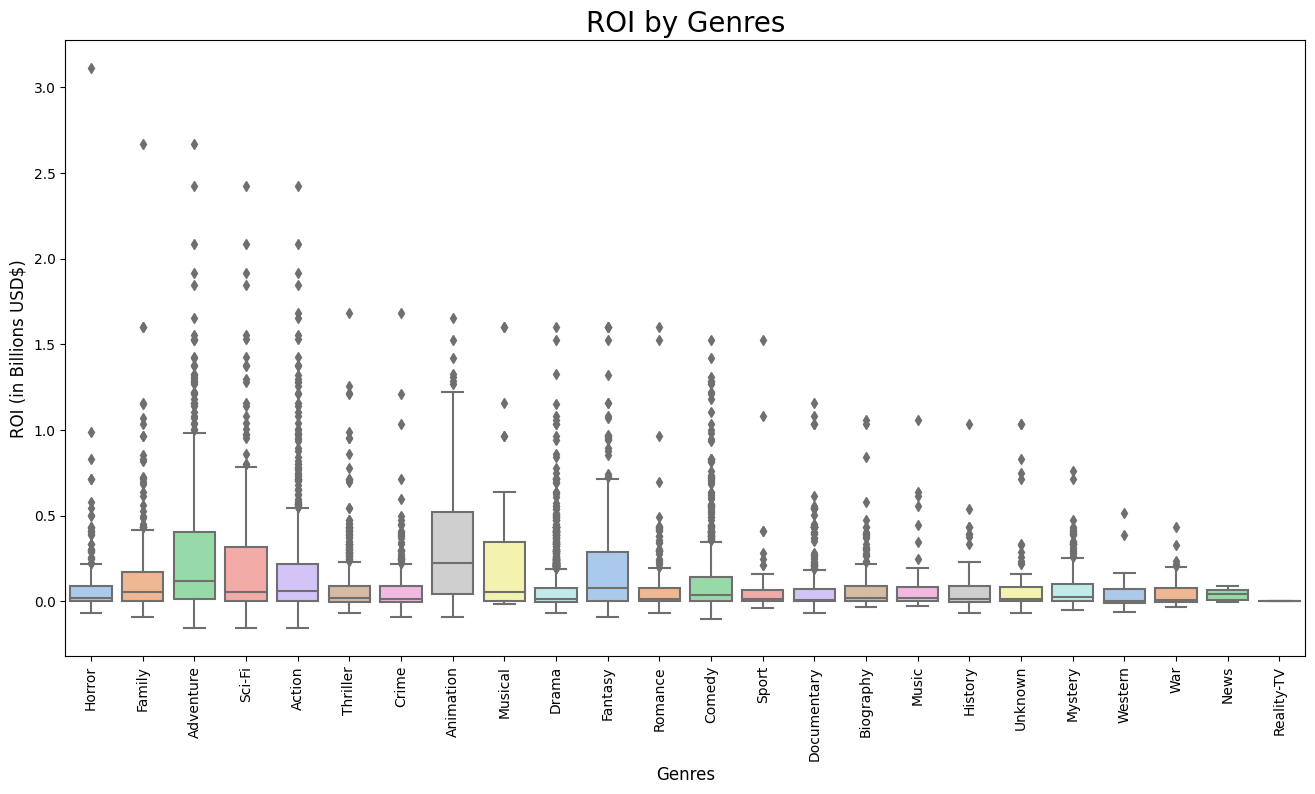

In [102]:
# The overall IQR of the genres across the entire dataset
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x = 'genres', y=('ROI'), data = newdf2, palette="pastel")
plt.title('ROI by Genres', fontsize=20)
plt.xlabel('Genres', fontsize=12)
plt.ylabel('ROI (in Billions USD$)', fontsize=12)
ytick_values = [0, 0.5e9, 1e9, 1.5e9, 2e9, 2.5e9, 3e9]
ytick_labels = []
for value in ytick_values:
    label = (str(float(value/1000000000)))
    ytick_labels.append(label)
plt.yticks(ticks=ytick_values, labels=ytick_labels)
plt.xticks(rotation=90);
#1,000,000,000

#3 CSV - movie grosses, bom.movie_gross.csv

In [103]:
# This is the CSV containing  movie names and their domestic grosses and foreign grosses.  At this time it is not incorporate into any visuals, but studio info is
#  unique to this table.

# In this table, title has no missing values, but not sure if all unique, adding an index might be necessary
movie_grosses = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/bom.movie_gross.csv.gz', sep=',')

print(movie_grosses.dtypes)
print(movie_grosses.tail(5))
print('\n')

missing_values(movie_grosses)

title              object
studio             object
domestic_gross    float64
foreign_gross      object
year                int64
dtype: object
                            title      studio  domestic_gross foreign_gross   
3382                    The Quake       Magn.          6200.0           NaN  \
3383  Edward II (2018 re-release)          FM          4800.0           NaN   
3384                     El Pacto        Sony          2500.0           NaN   
3385                     The Swan  Synergetic          2400.0           NaN   
3386            An Actor Prepares       Grav.          1700.0           NaN   

      year  
3382  2018  
3383  2018  
3384  2018  
3385  2018  
3386  2018  


Missing values by Column
title: 0 missing values
studio: 5 missing values
domestic_gross: 28 missing values
foreign_gross: 1350 missing values
year: 0 missing values


#4 TSV - movie info, rt.movie_info.tsv 
-----THIS IS THE FILE WITH SYNOPSES, USED TO START TO BUILD A MOVIE SCRIPT ANALYZER ----------

In [104]:
# This is the CSV with movie information with columns: id, synopsis, rating, genre, director, writer, theater_date, dvd_date, currency, box_office, runtime, studio.
# ID has type int64, all others are mixed type objects and may need cleaning. 


movie_info = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/rt.movie_info.tsv', sep='\t')
print(movie_info.head(2))

#print(movie_info.dtypes)
#print(movie_info.shape) # Shape is (1560 by 12)

# Assert that 'id' is a unique record and there are no missing values
assert movie_info["id"].isna().sum() == 0

#Using missing values function to count NaNs per column
missing_values(movie_info)

   id                                           synopsis rating   
0   1  This gritty, fast-paced, and innovative police...      R  \
1   3  New York City, not-too-distant-future: Eric Pa...      R   

                                 genre          director   
0  Action and Adventure|Classics|Drama  William Friedkin  \
1    Drama|Science Fiction and Fantasy  David Cronenberg   

                         writer  theater_date      dvd_date currency   
0                Ernest Tidyman   Oct 9, 1971  Sep 25, 2001      NaN  \
1  David Cronenberg|Don DeLillo  Aug 17, 2012   Jan 1, 2013        $   

  box_office      runtime             studio  
0        NaN  104 minutes                NaN  
1    600,000  108 minutes  Entertainment One  
Missing values by Column
id: 0 missing values
synopsis: 62 missing values
rating: 3 missing values
genre: 8 missing values
director: 199 missing values
writer: 449 missing values
theater_date: 359 missing values
dvd_date: 359 missing values
currency: 1220 mis

#5 TSV - reviews, rt.reviews.tsv

In [105]:
#5) TSV - reviews, rt.reviews.tsv
# ratings is in multiple different forms and would need manipulation, but because there is no movie name, or even a synopsis, it would be very difficult to match it to
# anything

movie_info = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/rt.reviews.tsv', sep='\t', encoding='latin1')
print(movie_info.tail(5))

print(movie_info.dtypes)
print(movie_info.shape) # Shape is (1560 by 12)

# Assert that 'id' is a unique record and there are no missing values
assert movie_info["id"].isna().sum() == 0

#Using missing values function to count NaNs per column
missing_values(movie_info)

         id                                             review rating   fresh   
54427  2000  The real charm of this trifle is the deadpan c...    NaN   fresh  \
54428  2000                                                NaN    1/5  rotten   
54429  2000                                                NaN    2/5  rotten   
54430  2000                                                NaN  2.5/5  rotten   
54431  2000                                                NaN    3/5   fresh   

                  critic  top_critic        publisher                date  
54427      Laura Sinagra           1    Village Voice  September 24, 2002  
54428  Michael Szymanski           0       Zap2it.com  September 21, 2005  
54429       Emanuel Levy           0  EmanuelLevy.Com       July 17, 2005  
54430   Christopher Null           0   Filmcritic.com   September 7, 2003  
54431    Nicolas Lacroix           0     Showbizz.net   November 12, 2002  
id             int64
review        object
rating        o

#6 CSV - Movies, tmbdb_movies.csv

In [106]:
#6) CSV - movies, tmdb_movies.csv
import pandas as pd

movie_tmdb = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/tmdb.movies.csv', sep=',')

#print(movie_tmdb.dtypes)
print(movie_tmdb.head(2))
print('\n')

# Assert that 'id' is a unique record and there are no missing values
assert movie_tmdb["id"].isna().sum() == 0
 # Drop Unnamed column which is just another index, as it seems to cause issues later with the merge, creating duplicate entries and we already have an index and unique id
movie_tmdb.drop('Unnamed: 0', axis=1, inplace=True)

   Unnamed: 0            genre_ids     id original_language   
0           0      [12, 14, 10751]  12444                en  \
1           1  [14, 12, 16, 10751]  10191                en   

                                 original_title  popularity release_date   
0  Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19  \
1                      How to Train Your Dragon      28.734   2010-03-26   

                                          title  vote_average  vote_count  
0  Harry Potter and the Deathly Hallows: Part 1           7.7       10788  
1                      How to Train Your Dragon           7.7        7610  




In [107]:
missing_values(movie_tmdb)

Missing values by Column
genre_ids: 0 missing values
id: 0 missing values
original_language: 0 missing values
original_title: 0 missing values
popularity: 0 missing values
release_date: 0 missing values
title: 0 missing values
vote_average: 0 missing values
vote_count: 0 missing values


In [108]:
import json
# TMDB API call is handled in TMDB_APICall.ipynb
# This is where I open and read the saved dict translation table from the API call
# which should be saved at "/home/bringingthesparkle/FlatIron/genre_ids.txt"
# Using retrieve_dict() functions.  Provide the file path when prompted.

file2 = open("/home/bringingthesparkle/FlatIron/genre_ids.txt", "r")
file2_string = file2.read()
file2.close()
print("This is the string read from file: " + file2_string)
file2_dict = eval(file2_string) #I know that eval is ill-advised, but need to find a different way (or build)
# using json.loads() method
result = json.loads(file2_string)

This is the string read from file: {"genres":[{"id":28,"name":"Action"},{"id":12,"name":"Adventure"},{"id":16,"name":"Animation"},{"id":35,"name":"Comedy"},{"id":80,"name":"Crime"},{"id":99,"name":"Documentary"},{"id":18,"name":"Drama"},{"id":10751,"name":"Family"},{"id":14,"name":"Fantasy"},{"id":36,"name":"History"},{"id":27,"name":"Horror"},{"id":10402,"name":"Music"},{"id":9648,"name":"Mystery"},{"id":10749,"name":"Romance"},{"id":878,"name":"Science Fiction"},{"id":10770,"name":"TV Movie"},{"id":53,"name":"Thriller"},{"id":10752,"name":"War"},{"id":37,"name":"Western"}]}


In [109]:
#print(result)
genre_list = result['genres']
#print(len(genre_list))
print(genre_list)
# Use API generated list to create mapping to turn values into genre names
# this is what mapping looks like s.map({'cat': 'kitten', 'dog': 'puppy'})
map_dict = {}

for item in result['genres']:
    it = iter(item.values())
    first, second = next(it), next(it)
    map_dict[first] = second

print (map_dict)

#lets try the mapping out
s = pd.Series([28, 80, 17])
s.map(map_dict)

[{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 80, 'name': 'Crime'}, {'id': 99, 'name': 'Documentary'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 14, 'name': 'Fantasy'}, {'id': 36, 'name': 'History'}, {'id': 27, 'name': 'Horror'}, {'id': 10402, 'name': 'Music'}, {'id': 9648, 'name': 'Mystery'}, {'id': 10749, 'name': 'Romance'}, {'id': 878, 'name': 'Science Fiction'}, {'id': 10770, 'name': 'TV Movie'}, {'id': 53, 'name': 'Thriller'}, {'id': 10752, 'name': 'War'}, {'id': 37, 'name': 'Western'}]
{28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'}


0    Action
1     Crime
2       NaN
dtype: object

In [110]:
#Still have to coerce this into being a real string to use explode
movie_tmdb['genre_ids'] = movie_tmdb['genre_ids'].str.replace("[","").str.replace("]","")
movie_tmdb['genre_ids'] = movie_tmdb['genre_ids'].str.split(',')
tmdb_xplod = movie_tmdb.explode('genre_ids')
print(tmdb_xplod.head())

  genre_ids     id original_language   
0        12  12444                en  \
0        14  12444                en   
0     10751  12444                en   
1        14  10191                en   
1        12  10191                en   

                                 original_title  popularity release_date   
0  Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19  \
0  Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19   
0  Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19   
1                      How to Train Your Dragon      28.734   2010-03-26   
1                      How to Train Your Dragon      28.734   2010-03-26   

                                          title  vote_average  vote_count  
0  Harry Potter and the Deathly Hallows: Part 1           7.7       10788  
0  Harry Potter and the Deathly Hallows: Part 1           7.7       10788  
0  Harry Potter and the Deathly Hallows: Part 1           7.7       10788 

In [111]:
# Inner join top_25_pct of movie budgets df & movie_tmbd and on movie title. 
# I know that I will have to update one of the field before the merge to get accurate result, but then I'll have to do this anyway, so... doing this part first.

title_merge_df = pd.merge(top_25_pct, tmdb_xplod, left_on='movie', right_on='original_title', how='left')
print((title_merge_df.shape)) # Without cleaning the titles up, we get an inner join that yields 2316 records 
# movie_budgets original length is 5782 records, top_25_percent is 
title_merge_df.head(10)

(2729, 16)


,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,ROI,genre_ids,id_y,original_language,original_title,popularity,release_date_y,title,vote_average,vote_count
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,28,19995.0,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676.0
1,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,12,19995.0,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676.0
2,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,14,19995.0,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676.0
3,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,878,19995.0,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676.0
4,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2683973445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2426949682,12,299536.0,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948.0
7,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2426949682,28,299536.0,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948.0
8,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2426949682,14,299536.0,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948.0
9,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,2086125489,28,135397.0,en,Jurassic World,20.709,2015-06-12,Jurassic World,6.6,14056.0


In [112]:
#Data cleaning on language category. 

#Replace nans in "original_language" with "unk" 
title_merge_df['original_language'].fillna('Unknown', inplace=True)
print(set(title_merge_df['original_language']))

#Replace languages with their full word (to make labels on the Seaborn Plot automatic)
title_merge_df['original_language'].replace(to_replace='en', value='English', inplace=True)
title_merge_df['original_language'].replace(to_replace='ja', value='Japanese', inplace=True)
title_merge_df['original_language'].replace(to_replace='es', value='Spanish', inplace=True)
title_merge_df['original_language'].replace(to_replace='te', value='Telegu', inplace=True)
title_merge_df['original_language'].replace(to_replace=np.nan, value='Unknown', inplace=True)
print(set(title_merge_df['original_language']))

{'es', 'Unknown', 'ja', 'te', 'en'}
{'Spanish', 'Unknown', 'Japanese', 'Telegu', 'English'}


In [113]:
print(title_merge_df.head())

   id_x release_date_x                                 movie   
0     1   Dec 18, 2009                                Avatar  \
1     1   Dec 18, 2009                                Avatar   
2     1   Dec 18, 2009                                Avatar   
3     1   Dec 18, 2009                                Avatar   
4     6   Dec 18, 2015  Star Wars Ep. VII: The Force Awakens   

   production_budget  domestic_gross  worldwide_gross         ROI genre_ids   
0          425000000       760507625       2776345279  3111852904        28  \
1          425000000       760507625       2776345279  3111852904        12   
2          425000000       760507625       2776345279  3111852904        14   
3          425000000       760507625       2776345279  3111852904       878   
4          306000000       936662225       2053311220  2683973445       NaN   

      id_y original_language original_title  popularity release_date_y   
0  19995.0           English         Avatar      26.526     2009-1

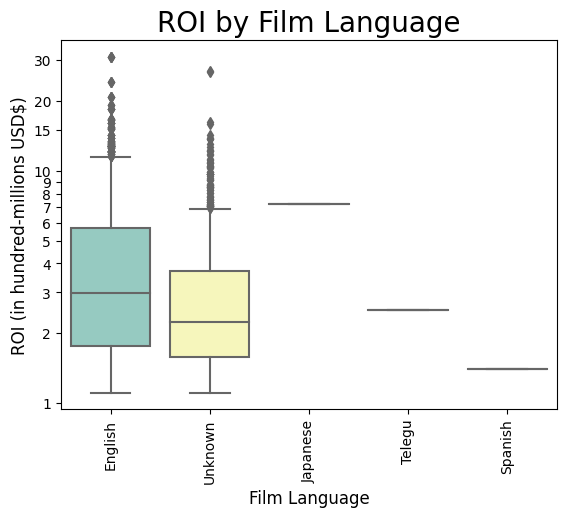

In [114]:
sns.boxplot(x = 'original_language', y='ROI', data = title_merge_df, palette="Set3")

plt.yscale('log')
plt.title('ROI by Film Language', fontsize=20)
plt.xlabel('Film Language', fontsize=12)
plt.ylabel('ROI (in hundred-millions USD$)', fontsize=12)
#Once I changed to a log scaled axis, ticks appeared but without labels, so I had to write them out directly which is not ideal.  I tried working with the ScalarFormatter
# but that was going to take far too long for this project and will require further investigation.
ytick_values = [1e8, 2e8, 3e8, 4e8, 5e8, 6e8, 7e8, 8e8, 9e8, 1e9, 1.5e9, 2e9, 3e9]
ytick_labels = []
for value in ytick_values:
    label = (str(int(value/100000000)))
    ytick_labels.append(label)
plt.yticks(ticks=ytick_values, labels=ytick_labels)

plt.xticks(rotation=90);

In [115]:
title_merge_df.head(5)  

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,ROI,genre_ids,id_y,original_language,original_title,popularity,release_date_y,title,vote_average,vote_count
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,28,19995.0,English,Avatar,26.526,2009-12-18,Avatar,7.4,18676.0
1,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,12,19995.0,English,Avatar,26.526,2009-12-18,Avatar,7.4,18676.0
2,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,14,19995.0,English,Avatar,26.526,2009-12-18,Avatar,7.4,18676.0
3,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,878,19995.0,English,Avatar,26.526,2009-12-18,Avatar,7.4,18676.0
4,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2683973445,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
#cleaning on genre_ids
title_merge_df['genre_ids'].replace(to_replace=np.nan, value=0, inplace=True)
title_merge_df.dtypes

id_x                   int64
release_date_x        object
movie                 object
production_budget      int64
domestic_gross         int64
worldwide_gross        int64
ROI                    int64
genre_ids             object
id_y                 float64
original_language     object
original_title        object
popularity           float64
release_date_y        object
title                 object
vote_average         float64
vote_count           float64
dtype: object

In [117]:
title_merge_df.head()

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,ROI,genre_ids,id_y,original_language,original_title,popularity,release_date_y,title,vote_average,vote_count
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,28,19995.0,English,Avatar,26.526,2009-12-18,Avatar,7.4,18676.0
1,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,12,19995.0,English,Avatar,26.526,2009-12-18,Avatar,7.4,18676.0
2,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,14,19995.0,English,Avatar,26.526,2009-12-18,Avatar,7.4,18676.0
3,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,878,19995.0,English,Avatar,26.526,2009-12-18,Avatar,7.4,18676.0
4,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2683973445,0,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
# Still working on getting this mapping to work properly
s = pd.Series([28, 80, 17])
print(s.map(map_dict))

listxyz = [title_merge_df['genre_ids']]
print(listxyz)
title_merge_df['genre_ids'].map(map_dict)

0    Action
1     Crime
2       NaN
dtype: object
[0           28
1           12
2           14
3          878
4            0
         ...  
2724        18
2725        16
2726     10751
2727        35
2728         0
Name: genre_ids, Length: 2729, dtype: object]


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
2724    NaN
2725    NaN
2726    NaN
2727    NaN
2728    NaN
Name: genre_ids, Length: 2729, dtype: object